In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, log_loss, accuracy_score
from sklearn.impute import KNNImputer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.cluster import KMeans

import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

import plotly.graph_objs as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

### Step 1 :  Exploratory Data Analysis (EDA)

In [2]:
data = pd.read_csv("Amazon Sale Report.csv",low_memory=False)
data.shape

(128975, 24)

In [3]:
data.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [4]:
data.dtypes

index                   int64
Order ID               object
Date                   object
Status                 object
Fulfilment             object
Sales Channel          object
ship-service-level     object
Style                  object
SKU                    object
Category               object
Size                   object
ASIN                   object
Courier Status         object
Qty                     int64
currency               object
Amount                float64
ship-city              object
ship-state             object
ship-postal-code      float64
ship-country           object
promotion-ids          object
B2B                      bool
fulfilled-by           object
Unnamed: 22            object
dtype: object

In [5]:
duplicates = data.duplicated()

num_duplicates = duplicates.sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 0


In [6]:
numeric_summary = data.describe()
numeric_summary

,index,Qty,Amount,ship-postal-code
count,128975.000000,128975.000000,121180.000000,128942.000000
mean,64487.000000,0.904431,648.561465,463966.236509
std,37232.019822,0.313354,281.211687,191476.764941
min,0.000000,0.000000,0.000000,110001.000000
25%,32243.500000,1.000000,449.000000,382421.000000
50%,64487.000000,1.000000,605.000000,500033.000000
75%,96730.500000,1.000000,788.000000,600024.000000
max,128974.000000,15.000000,5584.000000,989898.000000


In [7]:
categorical_summary = data.describe(include=[object,bool])
categorical_summary

,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,currency,ship-city,ship-state,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
count,128975,128975,128975,128975,128975,128975,128975,128975,128975,128975,128975,122103,121180,128942,128942,128942,79822,128975,39277,79925
unique,120378,91,13,2,2,2,1377,7195,9,11,7190,3,1,8955,69,1,5787,2,1,1
top,171-5057375-2831560,05-03-22,Shipped,Amazon,Amazon.in,Expedited,JNE3797,JNE3797-KR-L,Set,M,B09SDXFFQ1,Shipped,INR,BENGALURU,MAHARASHTRA,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,Easy Ship,False
freq,12,2085,77804,89698,128851,88615,4224,773,50284,22711,773,109487,121180,11217,22260,128942,46100,128104,39277,79925


In [8]:
print(data.isnull().sum().sum())
null_counts = data.isnull().sum()
columns_with_null = null_counts[null_counts > 0]
columns_with_null

210495


Courier Status       6872
currency             7795
Amount               7795
ship-city              33
ship-state             33
ship-postal-code       33
ship-country           33
promotion-ids       49153
fulfilled-by        89698
Unnamed: 22         49050
dtype: int64

```c++
From the above EDA we can conclude :
1)columns [Currency , ship-country , Fulfilled by , Unnamed-32] contains only one unique value , so it can be dropped 
2)columns [Qty , Amount] need to be scaled due to huge difference in their distribution 
3)column date need to be converted from object data type to datetime 
4)column postal code is numeric column but its characteristic is for categorical column 
5)columns [ship-country , ship-city , ship-state , ship-postal-code] are considered as hierarchical features starting from country to postal-code , so we can keep the column with the lowest granularity which is postal code and drop the others   
6)column 'fulfilled-by' has 89698 null values which means that approximately 69.5% of the column is missing , so this column will be dropped as imputing it will be misleading , and also it contains only one variable 
7)columns 'promotion-ids' has null values 49153  which will be dropped also due to large number of missing values**

```

### Step 2 : Data Preprocessing

In [9]:
cleaned_data = data.drop(columns=['currency','ship-country','fulfilled-by','Unnamed: 22','ship-city','ship-state','promotion-ids'])

In [10]:
cleaned_data = cleaned_data.drop(['index', 'Order ID'],axis=1)

In [11]:
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], format='%m-%d-%y')

In [12]:
cleaned_data['Year'] = cleaned_data['Date'].dt.year
cleaned_data['Month'] = cleaned_data['Date'].dt.month
cleaned_data['Day'] = cleaned_data['Date'].dt.day

In [13]:
print(cleaned_data['Year'].nunique())
print(cleaned_data['Month'].nunique())
print(cleaned_data['Day'].nunique())

1
4
31


Year column will be dropped since it has only one value and the main date column will be dropped as we replaced it with 2 columns one for mounth and other for day

In [14]:
cleaned_data = cleaned_data.drop(['Year','Date'],axis=1)
cleaned_data

,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-postal-code,B2B,Month,Day
0,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,NaN,0,647.62,400081.0,False,4,30
1,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,406.00,560085.0,False,4,30
2,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,329.00,410210.0,True,4,30
3,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,NaN,0,753.33,605008.0,False,4,30
4,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,574.00,600073.0,False,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,Shipped,Amazon,Amazon.in,Expedited,JNE3697,JNE3697-KR-XL,kurta,XL,B098112V2V,Shipped,1,517.00,500013.0,False,5,31
128971,Shipped,Amazon,Amazon.in,Expedited,SET401,SET401-KR-NP-M,Set,M,B09VC6KHX8,Shipped,1,999.00,122004.0,False,5,31
128972,Shipped,Amazon,Amazon.in,Expedited,J0157,J0157-DR-XXL,Western Dress,XXL,B0982YZ51B,Shipped,1,690.00,500049.0,False,5,31
128973,Shipped,Amazon,Amazon.in,Expedited,J0012,J0012-SKD-XS,Set,XS,B0894Y2NJQ,Shipped,1,1199.00,389350.0,False,5,31


In [15]:
cleaned_data.dtypes

Status                 object
Fulfilment             object
Sales Channel          object
ship-service-level     object
Style                  object
SKU                    object
Category               object
Size                   object
ASIN                   object
Courier Status         object
Qty                     int64
Amount                float64
ship-postal-code      float64
B2B                      bool
Month                   int32
Day                     int32
dtype: object

In [16]:
cleaned_data

,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-postal-code,B2B,Month,Day
0,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,NaN,0,647.62,400081.0,False,4,30
1,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,406.00,560085.0,False,4,30
2,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,329.00,410210.0,True,4,30
3,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,NaN,0,753.33,605008.0,False,4,30
4,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,574.00,600073.0,False,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,Shipped,Amazon,Amazon.in,Expedited,JNE3697,JNE3697-KR-XL,kurta,XL,B098112V2V,Shipped,1,517.00,500013.0,False,5,31
128971,Shipped,Amazon,Amazon.in,Expedited,SET401,SET401-KR-NP-M,Set,M,B09VC6KHX8,Shipped,1,999.00,122004.0,False,5,31
128972,Shipped,Amazon,Amazon.in,Expedited,J0157,J0157-DR-XXL,Western Dress,XXL,B0982YZ51B,Shipped,1,690.00,500049.0,False,5,31
128973,Shipped,Amazon,Amazon.in,Expedited,J0012,J0012-SKD-XS,Set,XS,B0894Y2NJQ,Shipped,1,1199.00,389350.0,False,5,31


In [17]:
print("count of all nulls : ")
print(cleaned_data.isnull().sum().sum())
print("")
null_counts = cleaned_data.isnull().sum()
columns_with_null = null_counts[null_counts > 0]
print("Columns with nulls : ")
print(columns_with_null)

count of all nulls : 
14700

Columns with nulls : 
Courier Status      6872
Amount              7795
ship-postal-code      33
dtype: int64


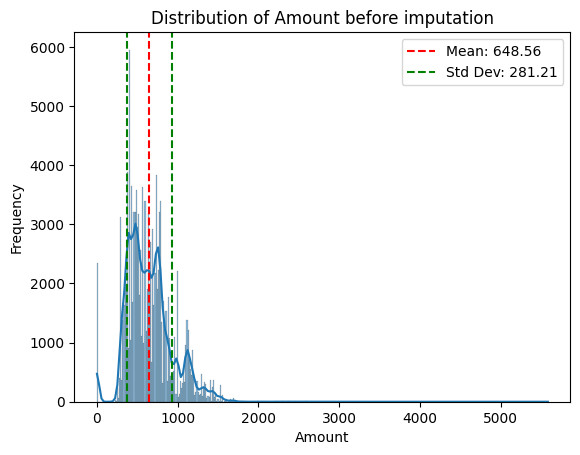

In [18]:
# distribution of Amount before imputation

mean_Amount = data['Amount'].mean()
std_Amount = data['Amount'].std()

sns.histplot(cleaned_data['Amount'], kde=True)

plt.title('Distribution of Amount before imputation')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.axvline(mean_Amount, color='r', linestyle='--', label=f'Mean: {mean_Amount:.2f}')
plt.axvline(mean_Amount + std_Amount, color='g', linestyle='--', label=f'Std Dev: {std_Amount:.2f}')
plt.axvline(mean_Amount - std_Amount, color='g', linestyle='--')

plt.legend()

plt.show()

In [19]:
# Imputation Using KNN
imputer = KNNImputer(n_neighbors=5)
cleaned_data['Amount'] = imputer.fit_transform(cleaned_data[['Amount']])

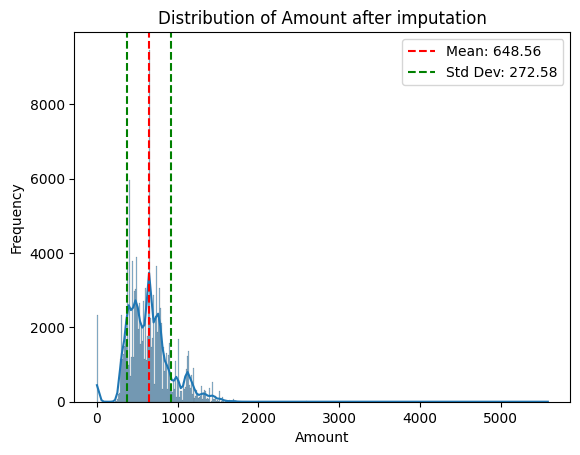

In [20]:
# distribution of Amount after imputation

mean_Amount = cleaned_data['Amount'].mean()
std_Amount = cleaned_data['Amount'].std()

sns.histplot(cleaned_data['Amount'], kde=True)

plt.title('Distribution of Amount after imputation')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.axvline(mean_Amount, color='r', linestyle='--', label=f'Mean: {mean_Amount:.2f}')
plt.axvline(mean_Amount + std_Amount, color='g', linestyle='--', label=f'Std Dev: {std_Amount:.2f}')
plt.axvline(mean_Amount - std_Amount, color='g', linestyle='--')

plt.legend()

plt.show()

In [21]:
print(cleaned_data.isnull().sum().sum())
null_counts = cleaned_data.isnull().sum()
columns_with_null = null_counts[null_counts > 0]
columns_with_null

6905


Courier Status      6872
ship-postal-code      33
dtype: int64

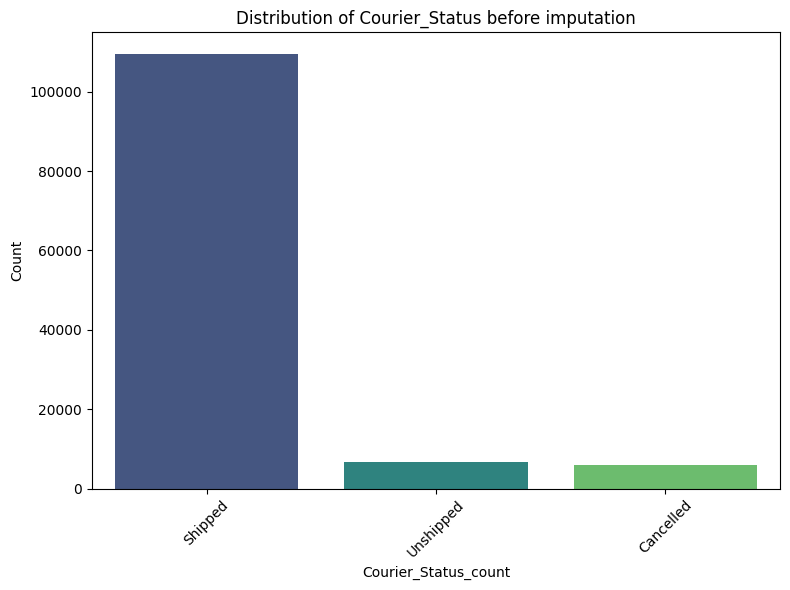

In [22]:
# Distribution of Courier Status before imputation
Courier_Status_count = cleaned_data['Courier Status'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=Courier_Status_count.index, y=Courier_Status_count.values, palette='viridis')

plt.title('Distribution of Courier_Status before imputation')
plt.xlabel('Courier_Status_count')
plt.ylabel('Count')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [23]:
Courier_Status_count

Courier Status
Shipped      109487
Unshipped      6681
Cancelled      5935
Name: count, dtype: int64

In [24]:
# Imputation of Courier Status using the probabillity of each class
Shipped = 109487
Unshipped = 6681
Cancelled = 5935

total_non_missing = Shipped + Unshipped + Cancelled

prop_Shipped = Shipped / total_non_missing
prop_Unshipped = Unshipped / total_non_missing
prop_Cancelled = Cancelled / total_non_missing


def impute_category(row):
    if pd.isna(row['Courier Status']):
        rand_val = np.random.random()
        if rand_val < prop_Shipped:
            return 'Shipped'
        elif rand_val < prop_Shipped + prop_Unshipped:
            return 'Unshipped'
        else:
            return 'Cancelled'
    else:
        return row['Courier Status']

cleaned_data['Courier Status'] = cleaned_data.apply(impute_category, axis=1)

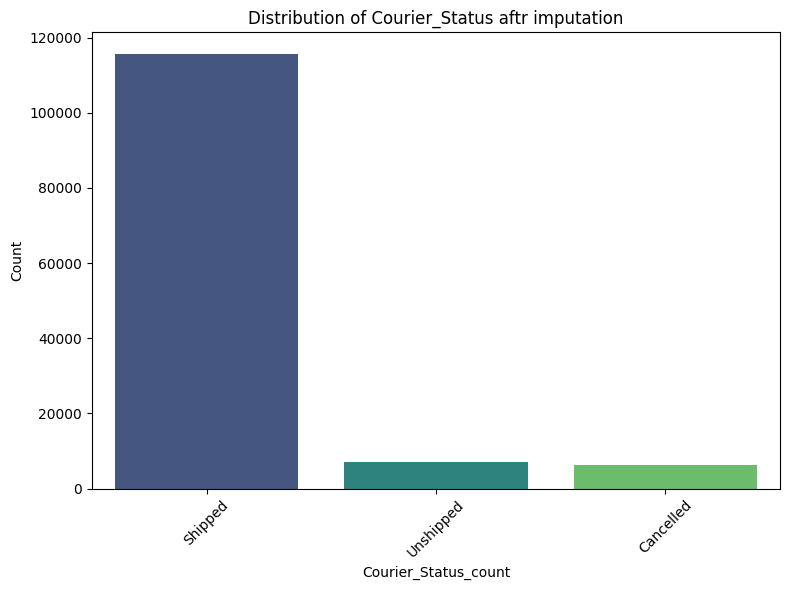

In [25]:
# Distribution of Courier Status after imputation
Courier_Status_count = cleaned_data['Courier Status'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=Courier_Status_count.index, y=Courier_Status_count.values, palette='viridis')

plt.title('Distribution of Courier_Status aftr imputation')
plt.xlabel('Courier_Status_count')
plt.ylabel('Count')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [26]:
Courier_Status_count

Courier Status
Shipped      115634
Unshipped      7038
Cancelled      6303
Name: count, dtype: int64

In [27]:
print(cleaned_data.isnull().sum().sum())
null_counts = cleaned_data.isnull().sum()
columns_with_null = null_counts[null_counts > 0]
columns_with_null

33


ship-postal-code    33
dtype: int64

In [28]:
cleaned_data = cleaned_data.dropna(subset=['ship-postal-code'])
cleaned_data

,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-postal-code,B2B,Month,Day
0,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,Shipped,0,647.62,400081.0,False,4,30
1,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,406.00,560085.0,False,4,30
2,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,329.00,410210.0,True,4,30
3,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,Shipped,0,753.33,605008.0,False,4,30
4,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,574.00,600073.0,False,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,Shipped,Amazon,Amazon.in,Expedited,JNE3697,JNE3697-KR-XL,kurta,XL,B098112V2V,Shipped,1,517.00,500013.0,False,5,31
128971,Shipped,Amazon,Amazon.in,Expedited,SET401,SET401-KR-NP-M,Set,M,B09VC6KHX8,Shipped,1,999.00,122004.0,False,5,31
128972,Shipped,Amazon,Amazon.in,Expedited,J0157,J0157-DR-XXL,Western Dress,XXL,B0982YZ51B,Shipped,1,690.00,500049.0,False,5,31
128973,Shipped,Amazon,Amazon.in,Expedited,J0012,J0012-SKD-XS,Set,XS,B0894Y2NJQ,Shipped,1,1199.00,389350.0,False,5,31


In [29]:
print(cleaned_data.isnull().sum().sum())
null_counts = cleaned_data.isnull().sum()
columns_with_null = null_counts[null_counts > 0]
columns_with_null

0


Series([], dtype: int64)

In [30]:
cleaned_data.dtypes

Status                 object
Fulfilment             object
Sales Channel          object
ship-service-level     object
Style                  object
SKU                    object
Category               object
Size                   object
ASIN                   object
Courier Status         object
Qty                     int64
Amount                float64
ship-postal-code      float64
B2B                      bool
Month                   int32
Day                     int32
dtype: object

In [31]:
label_encoder = LabelEncoder()

for column in cleaned_data.select_dtypes(include=['object','bool']).columns:
    cleaned_data[column] = label_encoder.fit_transform(cleaned_data[column])

cleaned_data.head()

,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-postal-code,B2B,Month,Day
0,0,1,0,1,1342,6992,5,7,5563,1,0,647.62,400081.0,0,4,30
1,5,1,0,1,847,4436,8,0,5277,1,1,406.00,560085.0,0,4,30
2,3,0,0,0,533,2633,8,8,675,1,1,329.00,410210.0,1,4,30
3,0,1,0,1,373,1767,7,5,4638,1,0,753.33,605008.0,0,4,30
4,3,0,0,0,754,3837,6,0,4351,1,1,574.00,600073.0,0,4,30


In [32]:
cleaned_data.describe()

,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-postal-code,B2B,Month,Day
count,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000,128942.000000
mean,3.162251,0.304509,0.000962,0.312908,762.461711,3880.122001,6.413923,6.359635,3717.434474,1.005700,0.904445,648.572589,463966.236509,0.006755,4.909207,14.926486
std,1.783830,0.460201,0.030996,0.463679,380.595819,2044.225833,1.521736,2.862953,2048.851327,0.321562,0.313340,272.591354,191476.764941,0.081911,0.818410,8.743023
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110001.000000,0.000000,3.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,438.000000,2143.000000,5.000000,5.000000,1843.000000,1.000000,1.000000,459.000000,382421.000000,0.000000,4.000000,7.000000
50%,3.000000,0.000000,0.000000,0.000000,777.000000,3971.000000,7.000000,7.000000,3887.000000,1.000000,1.000000,635.000000,500033.000000,0.000000,5.000000,15.000000
75%,3.000000,1.000000,0.000000,1.000000,1143.000000,5776.000000,8.000000,8.000000,5612.000000,1.000000,1.000000,771.000000,600024.000000,0.000000,6.000000,22.000000
max,12.000000,1.000000,1.000000,1.000000,1376.000000,7194.000000,8.000000,10.000000,7189.000000,2.000000,15.000000,5584.000000,989898.000000,1.000000,6.000000,31.000000


In [33]:
scaler = StandardScaler()

# excluding 'Courier Status' from scaling as it is our target column

numerical_features = cleaned_data.drop(['Courier Status'],axis=1).select_dtypes(include=['float64', 'int64', 'int32', 'float32']).columns
cleaned_data.loc[:, numerical_features] = scaler.fit_transform(cleaned_data.loc[:, numerical_features])

cleaned_data

,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-postal-code,B2B,Month,Day
0,-1.772738,1.511283,-0.031026,1.481832,1.522719,1.522283,-0.929155,0.223674,0.900784,1,-2.886479,-0.003495,-0.333646,-0.082468,-1.110947,1.724069
1,1.030231,1.511283,-0.031026,1.481832,0.222122,0.271927,1.042286,-2.221363,0.761193,1,0.304956,-0.889880,0.501989,-0.082468,-1.110947,1.724069
2,-0.090957,-0.661690,-0.031026,-0.674840,-0.602904,-0.610073,1.042286,0.572965,-1.484952,1,0.304956,-1.172355,-0.280747,12.125965,-1.110947,1.724069
3,-1.772738,1.511283,-0.031026,1.481832,-1.023299,-1.033707,0.385139,-0.474908,0.449310,1,-2.886479,0.384304,0.736603,-0.082468,-1.110947,1.724069
4,-0.090957,-0.661690,-0.031026,-0.674840,-0.022233,-0.021095,-0.272008,-2.221363,0.309231,1,0.304956,-0.273570,0.710829,-0.082468,-1.110947,1.724069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,-0.090957,-0.661690,-0.031026,-0.674840,0.030317,0.035651,1.042286,0.572965,0.118880,1,0.304956,-0.482675,0.188257,-0.082468,0.110938,1.838446
128971,-0.090957,-0.661690,-0.031026,-0.674840,1.548994,1.556037,-0.929155,-0.125617,1.521134,1,0.304956,1.285546,-1.785927,-0.082468,0.110938,1.838446
128972,-0.090957,-0.661690,-0.031026,-0.674840,-1.380635,-1.408911,0.385139,1.271547,0.173056,1,0.304956,0.151977,0.188445,-0.082468,0.110938,1.838446
128973,-0.090957,-0.661690,-0.031026,-0.674840,-1.688049,-1.695574,-0.929155,0.922256,-1.169652,1,0.304956,2.019248,-0.389690,-0.082468,0.110938,1.838446


Outlier counts:
Amount: 4176
Qty: 13190


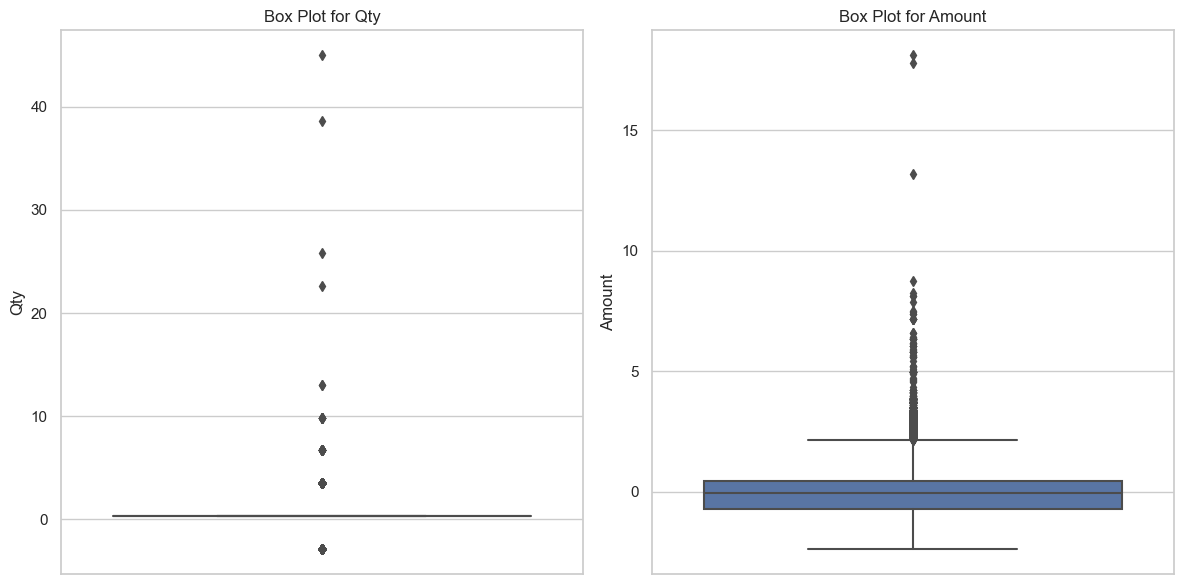

In [34]:
def count_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    return outlier_count

outlier_counts = {}
outlier_counts['Amount'] = count_outliers(cleaned_data, 'Amount')
outlier_counts['Qty'] = count_outliers(cleaned_data, 'Qty')

print("Outlier counts:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=cleaned_data, y='Qty', ax=axes[0])
axes[0].set_title('Box Plot for Qty')

sns.boxplot(data=cleaned_data, y='Amount', ax=axes[1])
axes[1].set_title('Box Plot for Amount')

plt.tight_layout()
plt.show()

In [35]:
# X = cleaned_data.drop(columns=['Courier Status'])
# y = cleaned_data['Courier Status']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# model = LogisticRegression(max_iter=1000, random_state=42)

# sfs = SFS(model,
#           k_features=(1, len(X.columns)),
#           forward=True,
#           scoring='accuracy',
#           cv=5)

# sfs.fit(X_train, y_train)

# print("Selected features:")
# print(sfs.k_feature_names_)
# print("Accuracy of the selected feature subset:", sfs.k_score_)

# X_train_selected = sfs.transform(X_train)
# X_test_selected = sfs.transform(X_test)

# model.fit(X_train_selected, y_train)

# y_pred = model.predict(X_test_selected)

# accuracy = accuracy_score(y_test, y_pred)
# print("Final accuracy on test set:", accuracy)

```c++
the above cell takes 8 minutes runtime but the ouput of it is 
Selected features:('Status', 'Fulfilment', 'Sales Channel ', 'Style', 'SKU', 'Category', 'ASIN', 'Qty', 'Amount', 'ship-postal-code', 'B2B', 'Month', 'Day')
Accuracy of the selected feature subset: 0.9920894326257302
Final accuracy on test set: 0.9915208231005869
```

In [36]:
cleaned_data = cleaned_data[['Status', 'Fulfilment', 'Sales Channel ', 'Style', 'SKU', 'Category', 'ASIN', 'Qty', 'Amount', 'ship-postal-code', 'B2B', 'Month', 'Day','Courier Status']]
cleaned_data

,Status,Fulfilment,Sales Channel,Style,SKU,Category,ASIN,Qty,Amount,ship-postal-code,B2B,Month,Day,Courier Status
0,-1.772738,1.511283,-0.031026,1.522719,1.522283,-0.929155,0.900784,-2.886479,-0.003495,-0.333646,-0.082468,-1.110947,1.724069,1
1,1.030231,1.511283,-0.031026,0.222122,0.271927,1.042286,0.761193,0.304956,-0.889880,0.501989,-0.082468,-1.110947,1.724069,1
2,-0.090957,-0.661690,-0.031026,-0.602904,-0.610073,1.042286,-1.484952,0.304956,-1.172355,-0.280747,12.125965,-1.110947,1.724069,1
3,-1.772738,1.511283,-0.031026,-1.023299,-1.033707,0.385139,0.449310,-2.886479,0.384304,0.736603,-0.082468,-1.110947,1.724069,1
4,-0.090957,-0.661690,-0.031026,-0.022233,-0.021095,-0.272008,0.309231,0.304956,-0.273570,0.710829,-0.082468,-1.110947,1.724069,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,-0.090957,-0.661690,-0.031026,0.030317,0.035651,1.042286,0.118880,0.304956,-0.482675,0.188257,-0.082468,0.110938,1.838446,1
128971,-0.090957,-0.661690,-0.031026,1.548994,1.556037,-0.929155,1.521134,0.304956,1.285546,-1.785927,-0.082468,0.110938,1.838446,1
128972,-0.090957,-0.661690,-0.031026,-1.380635,-1.408911,0.385139,0.173056,0.304956,0.151977,0.188445,-0.082468,0.110938,1.838446,1
128973,-0.090957,-0.661690,-0.031026,-1.688049,-1.695574,-0.929155,-1.169652,0.304956,2.019248,-0.389690,-0.082468,0.110938,1.838446,1


feature selected based on forward feature selection

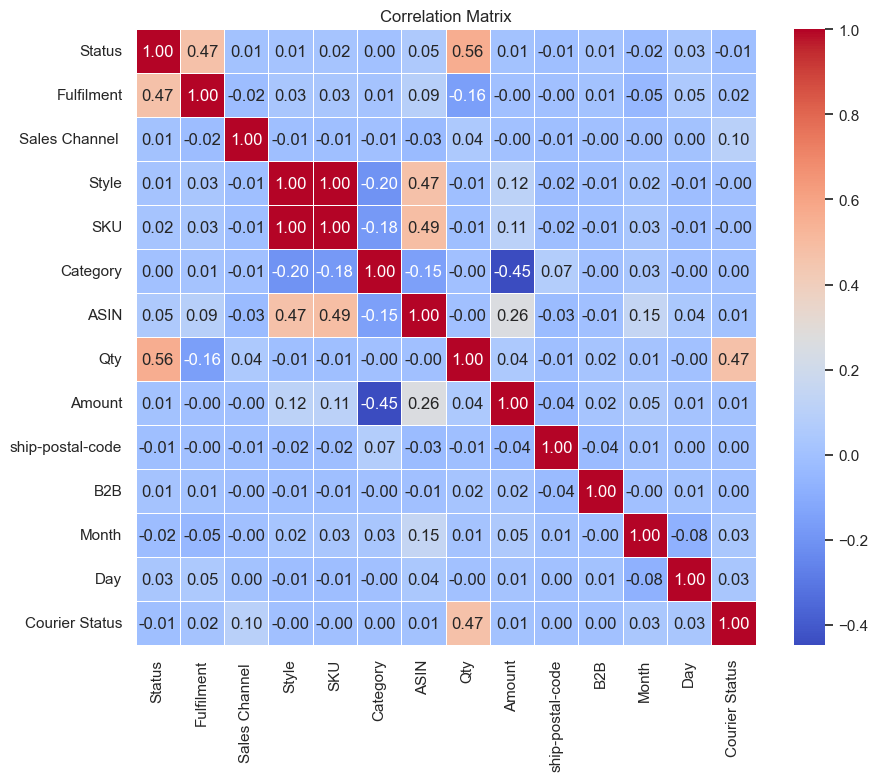

In [37]:
corr_matrix = cleaned_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Sku and style are nearly identical so one of them will be dropped (we will choose SKU)

In [38]:
cleaned_data = cleaned_data.drop(columns=['SKU'])

In [39]:
# from sklearn.neighbors import NearestNeighbors

# def hopkins(X):
#     d = X.shape[1]
#     n = len(X)
#     m = int(n)
#     nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
#     rand_X = np.random.random((m, d))
#     u_distances = []
#     for rand_x in rand_X:
#         u_distances.append(nbrs.kneighbors([rand_x], 2, return_distance=True)[0][0][1])
#     w_distances = []
#     sample_indices = np.random.choice(np.arange(n), m, replace=False)
#     for sample_index in sample_indices:
#         w_distances.append(nbrs.kneighbors([X.iloc[sample_index]], 2, return_distance=True)[0][0][1])
#     H = np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances))
#     return H

# hopkins_statistic = hopkins(cleaned_data)
# print(f"Hopkins statistic: {hopkins_statistic}")

This Cell Takes 3 minutes when we run it on the whole dataset ,
The Hopkins statistic is 0.891619922810035 which skows that the data has a good tend to be clustered

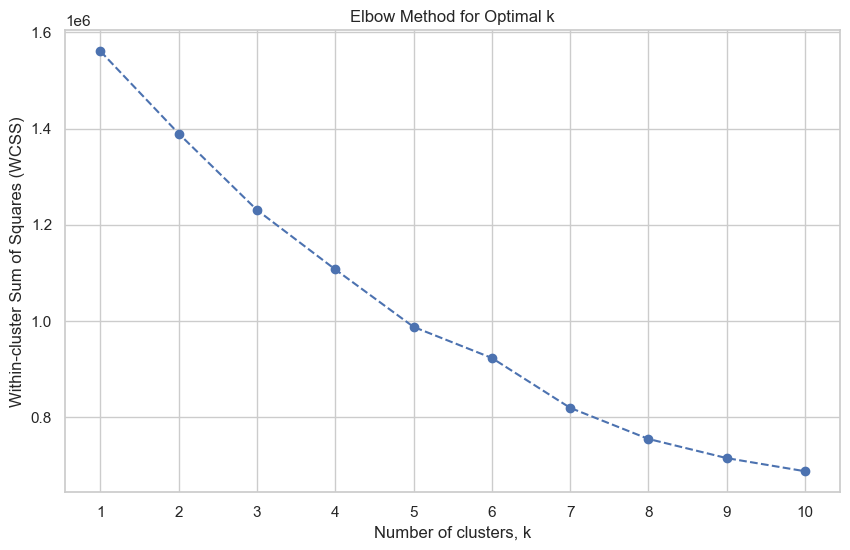

In [40]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(cleaned_data)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters, k')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

The elbow method shows that k = 6

In [41]:
k = 6
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
kmeans.fit(cleaned_data)
distances = kmeans.transform(cleaned_data)
nearest_distances = np.min(distances, axis=1)
threshold = np.mean(nearest_distances) + 2 * np.std(nearest_distances)
outliers_indices = np.where(nearest_distances > threshold)[0]
outliers_mask = np.zeros(len(cleaned_data), dtype=bool)
outliers_mask[outliers_indices] = True
print("Shape of outliers:", outliers_indices.shape)

Shape of outliers: (1650,)


In [42]:
cleaned_data = cleaned_data[~outliers_mask]
print("Cleaned data without outliers:")
cleaned_data

Cleaned data without outliers:


,Status,Fulfilment,Sales Channel,Style,Category,ASIN,Qty,Amount,ship-postal-code,B2B,Month,Day,Courier Status
0,-1.772738,1.511283,-0.031026,1.522719,-0.929155,0.900784,-2.886479,-0.003495,-0.333646,-0.082468,-1.110947,1.724069,1
1,1.030231,1.511283,-0.031026,0.222122,1.042286,0.761193,0.304956,-0.889880,0.501989,-0.082468,-1.110947,1.724069,1
3,-1.772738,1.511283,-0.031026,-1.023299,0.385139,0.449310,-2.886479,0.384304,0.736603,-0.082468,-1.110947,1.724069,1
4,-0.090957,-0.661690,-0.031026,-0.022233,-0.272008,0.309231,0.304956,-0.273570,0.710829,-0.082468,-1.110947,1.724069,1
5,-0.090957,-0.661690,-0.031026,1.244207,-0.929155,-0.379450,0.304956,0.643557,-1.372831,-0.082468,-1.110947,1.724069,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,-0.090957,-0.661690,-0.031026,0.030317,1.042286,0.118880,0.304956,-0.482675,0.188257,-0.082468,0.110938,1.838446,1
128971,-0.090957,-0.661690,-0.031026,1.548994,-0.929155,1.521134,0.304956,1.285546,-1.785927,-0.082468,0.110938,1.838446,1
128972,-0.090957,-0.661690,-0.031026,-1.380635,0.385139,0.173056,0.304956,0.151977,0.188445,-0.082468,0.110938,1.838446,1
128973,-0.090957,-0.661690,-0.031026,-1.688049,-0.929155,-1.169652,0.304956,2.019248,-0.389690,-0.082468,0.110938,1.838446,1


Outliers are dropped

### Step 3 Data Visuilization

In [45]:
df = pd.read_csv("Amazon Sale Report.csv",low_memory=False)

In [46]:
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

print(df['Year'].nunique())
print(df['Month'].nunique())
print(df['Day'].nunique())

1
4
31


In [47]:
df=df.drop(columns=['Year','Date'])

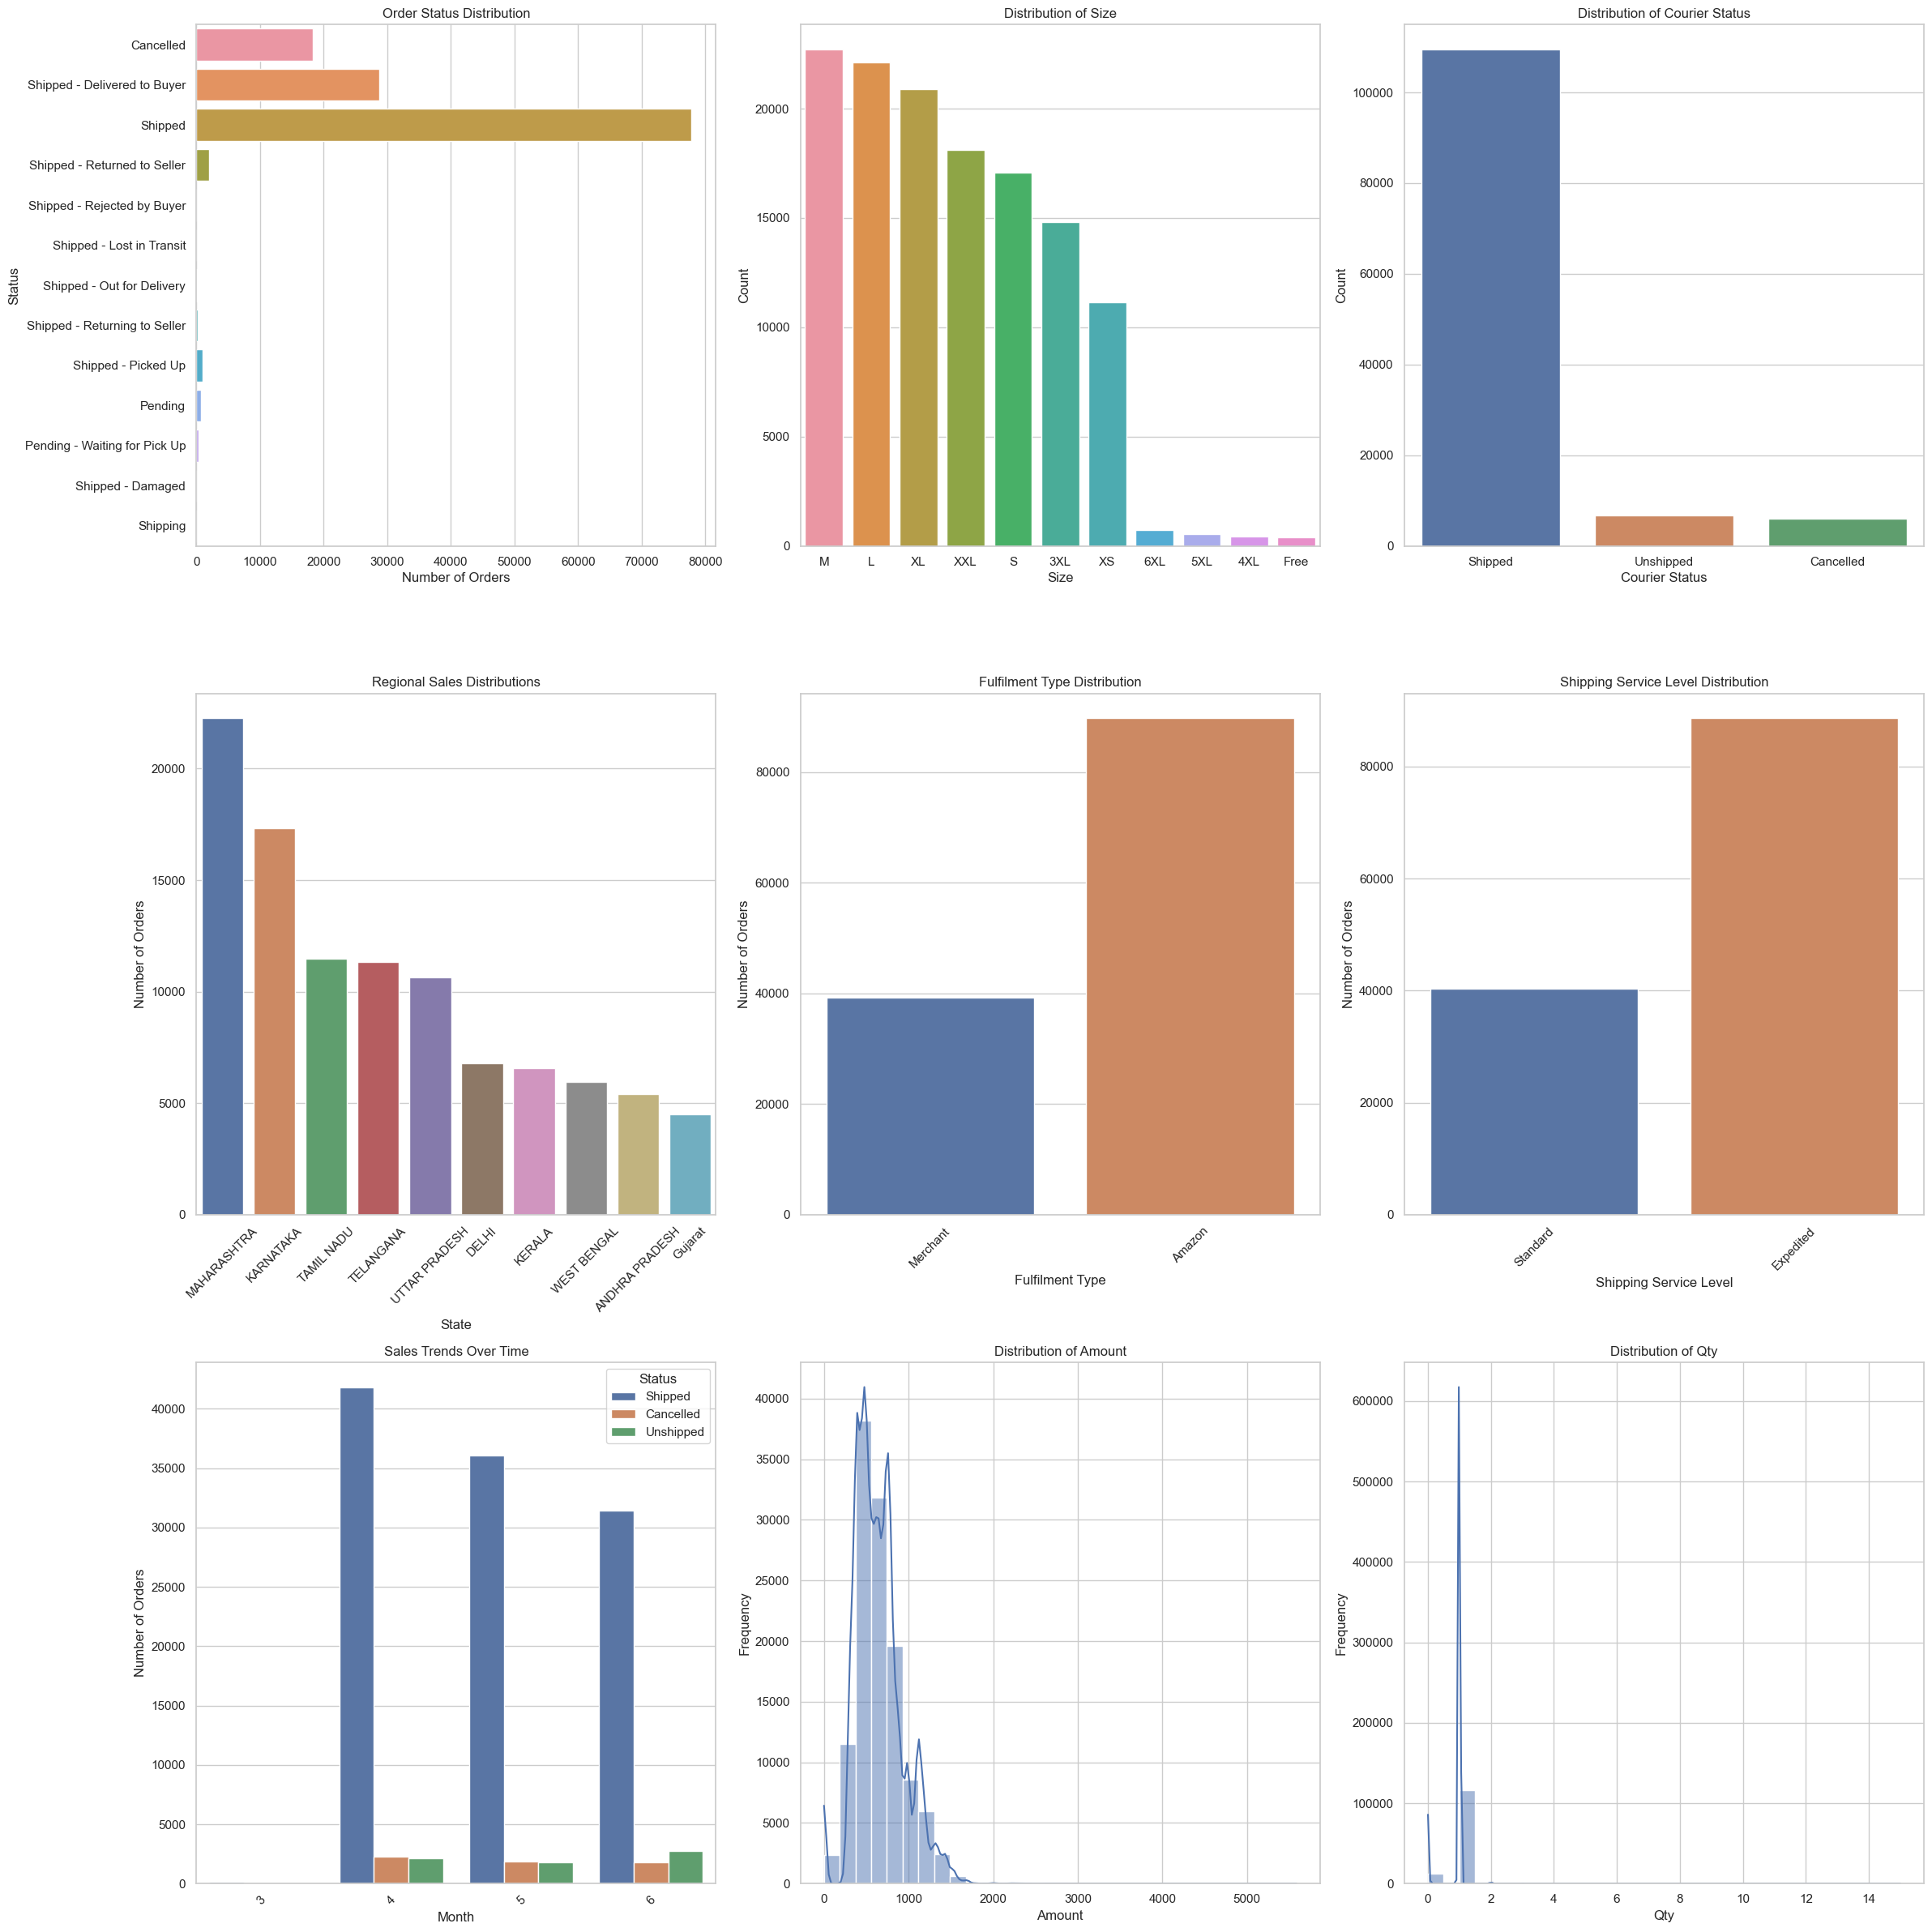

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))

# Order Status Distribution
sns.countplot(data=df, y='Status', ax=axes[0, 0])
axes[0, 0].set_title('Order Status Distribution')
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Status')
axes[0, 0].tick_params(axis='y', rotation=0)

# Distribution of Size
sns.countplot(x=df['Size'], order=df['Size'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Size')
axes[0, 1].set_xlabel('Size')
axes[0, 1].set_ylabel('Count')

# Distribution of Courier Status
sns.countplot(x=df['Courier Status'], order=df['Courier Status'].value_counts().index, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Courier Status')
axes[0, 2].set_xlabel('Courier Status')
axes[0, 2].set_ylabel('Count')

# Regional Sales Distributions
top_states = df['ship-state'].value_counts().nlargest(10)
sns.barplot(x=top_states.index, y=top_states.values, ax=axes[1, 0])
axes[1, 0].set_title('Regional Sales Distributions')
axes[1, 0].set_xlabel('State')
axes[1, 0].set_ylabel('Number of Orders')
axes[1, 0].tick_params(axis='x', rotation=45)

# Fulfilment Type Distribution
sns.countplot(data=df, x='Fulfilment', ax=axes[1, 1])
axes[1, 1].set_title('Fulfilment Type Distribution')
axes[1, 1].set_xlabel('Fulfilment Type')
axes[1, 1].set_ylabel('Number of Orders')
axes[1, 1].tick_params(axis='x', rotation=45)

# Shipping Service Level Distribution
sns.countplot(data=df, x='ship-service-level', ax=axes[1, 2])
axes[1, 2].set_title('Shipping Service Level Distribution')
axes[1, 2].set_xlabel('Shipping Service Level')
axes[1, 2].set_ylabel('Number of Orders')
axes[1, 2].tick_params(axis='x', rotation=45)

# Sales Trends Over Time
sns.countplot(data=df, x='Month', hue='Courier Status', ax=axes[2, 0])
axes[2, 0].set_title('Sales Trends Over Time')
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('Number of Orders')
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].legend(title='Status')

# Distribution of Amount
sns.histplot(df['Amount'], kde=True, bins=30, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Amount')
axes[2, 1].set_xlabel('Amount')
axes[2, 1].set_ylabel('Frequency')

# Distribution of Qty
sns.histplot(df['Qty'], kde=True, bins=30, ax=axes[2, 2])
axes[2, 2].set_title('Distribution of Qty')
axes[2, 2].set_xlabel('Qty')
axes[2, 2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


### Step 4: Predictive Modeling

In [49]:
data["Courier Status"].value_counts()

Courier Status
Shipped      109487
Unshipped      6681
Cancelled      5935
Name: count, dtype: int64

Due to the big diffrence between the classes in our targer Feature we will use a resampling technique called SMOTE

Test Set Metrics:
Confusion Matrix (Test):


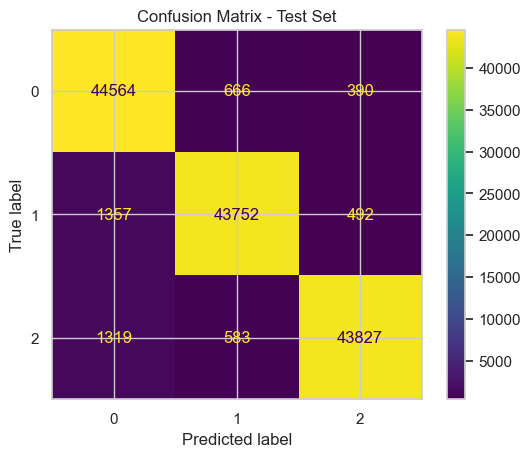

Precision (Test): 0.9653
Recall (Test): 0.9649
F1-score (Test): 0.9649

-----------------------------------------------------------------

Train Set Metrics:
Confusion Matrix (Train):


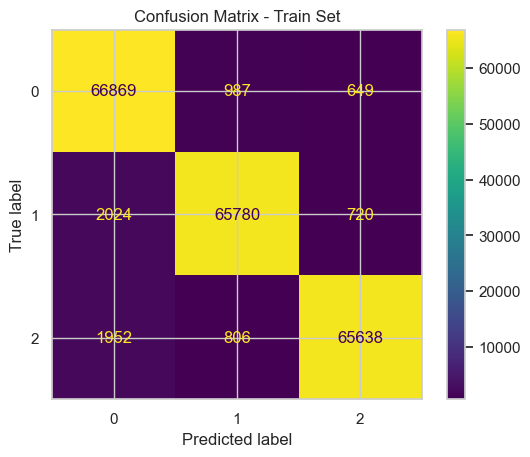

Precision (Train): 0.9656
Recall (Train): 0.9653
F1-score (Train): 0.9653


In [50]:
x = cleaned_data.drop(["Courier Status"], axis=1)
y = cleaned_data["Courier Status"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Test Set Metrics:")
y_pred_test = model.predict(X_test)

conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test):")
ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.title("Confusion Matrix - Test Set")
plt.show()

precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')

print(f"Precision (Test): {precision_test:.4f}")
print(f"Recall (Test): {recall_test:.4f}")
print(f"F1-score (Test): {f1_test:.4f}")

print("\n-----------------------------------------------------------------\n")

print("Train Set Metrics:")
y_pred_train = model.predict(X_train)

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Train):")
ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title("Confusion Matrix - Train Set")
plt.show()

precision_train = precision_score(y_train, y_pred_train, average='macro')
recall_train = recall_score(y_train, y_pred_train, average='macro')
f1_train = f1_score(y_train, y_pred_train, average='macro')

print(f"Precision (Train): {precision_train:.4f}")
print(f"Recall (Train): {recall_train:.4f}")
print(f"F1-score (Train): {f1_train:.4f}")


```json
From the above result we conclude that The logistic regression model exhibits high precision, recall, and F1-score on both the training and test datasets, indicating excellent performance and minimal overfitting. The close alignment of performance metrics between the training and test sets further confirms the model's generalization capability.
```

In [51]:
test_log_loss = log_loss(y_test, model.predict_proba(X_test))
print("Test Log Loss:", test_log_loss)

train_log_loss = log_loss(y_train, model.predict_proba(X_train))
print("Train Log Loss:", train_log_loss)

Test Log Loss: 0.06369148004036483
Train Log Loss: 0.06321944505656932


The Loss diffrence is too low between train and test so there is no overfitting

In [52]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring_metrics)

print("Cross-Validation Results:")
for fold_idx in range(5):
    print(f"Fold {fold_idx + 1}:")
    print(f"Accuracy  : {cv_results['test_accuracy'][fold_idx]:.4f}")
    print(f"Precision : {cv_results['test_precision_macro'][fold_idx]:.4f}")
    print(f"Recall    : {cv_results['test_recall_macro'][fold_idx]:.4f}")
    print(f"F1-score  : {cv_results['test_f1_macro'][fold_idx]:.4f}")
    print()

print("Mean Scores:")
print(f"Mean Accuracy  : {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Precision : {cv_results['test_precision_macro'].mean():.4f}")
print(f"Mean Recall    : {cv_results['test_recall_macro'].mean():.4f}")
print(f"Mean F1-score  : {cv_results['test_f1_macro'].mean():.4f}")

Cross-Validation Results:
Fold 1:
Accuracy  : 0.9648
Precision : 0.9651
Recall    : 0.9648
F1-score  : 0.9649

Fold 2:
Accuracy  : 0.9651
Precision : 0.9655
Recall    : 0.9651
F1-score  : 0.9652

Fold 3:
Accuracy  : 0.9642
Precision : 0.9648
Recall    : 0.9642
F1-score  : 0.9643

Fold 4:
Accuracy  : 0.9650
Precision : 0.9654
Recall    : 0.9649
F1-score  : 0.9650

Fold 5:
Accuracy  : 0.9660
Precision : 0.9663
Recall    : 0.9660
F1-score  : 0.9660

Mean Scores:
Mean Accuracy  : 0.9650
Mean Precision : 0.9654
Mean Recall    : 0.9650
Mean F1-score  : 0.9651


From the 5 folds we concluded that the stabillity of the training process across diffrent folds

### Step 5  Dashboard Development

In [53]:
# Grouping data for second dashboard
orders_per_day_month = df.groupby(['Month', 'Day']).size().reset_index(name='Number of Orders')

# Define your colors
colors = {
    'background': '#f9f9f9',
    'text': '#333333',
    'accent_color': '#1f77b4',
    'accent_color2': '#ff7f0e',
    'accent_color3': '#2ca02c',
    'grid_color': '#dddddd',
}

# List of colors to use for the lines
line_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A1FF33', '#5733FF']

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# App layout
app.layout = dbc.Container(
    fluid=True,
    style={'backgroundColor': colors['background'], 'padding': '20px'},
    children=[
        dbc.Row(
            dbc.Col(
                html.H1(
                    children='Sales Dashboard',
                    style={'textAlign': 'center', 'color': colors['text']}
                )
            )
        ),
        
        dbc.Row(
            dbc.Col(
                dcc.Graph(
                    id='graph1',
                    figure={
                        'data': [
                            {'x': orders_per_day_month[orders_per_day_month['Month'] == month]['Day'],
                             'y': orders_per_day_month[orders_per_day_month['Month'] == month]['Number of Orders'],
                             'type': 'line', 'name': f'Month {month}',
                             'line': {'color': line_colors[i % len(line_colors)]}}
                            for i, month in enumerate(orders_per_day_month['Month'].unique())
                        ],
                        'layout': {
                            'title': 'Number of Orders by Day for Each Month',
                            'xaxis': {'title': 'Day of the Month', 'gridcolor': colors['grid_color']},
                            'yaxis': {'title': 'Number of Orders', 'gridcolor': colors['grid_color']},
                            'plot_bgcolor': colors['background'],
                            'paper_bgcolor': colors['background'],
                            'font': {'color': colors['text']}
                        }
                    }
                ),
                width=12
            )
        ),
        dbc.Row(
            dbc.Col(
                html.Label("Select Month"),
                width=12,
                style={'marginBottom': '20px'}
            )
        ),
        dbc.Row(
            dbc.Col(
                dcc.Dropdown(
                    id='month-dropdown',
                    options=[{'label': month, 'value': month} for month in df['Month'].unique()],
                    value=df['Month'].unique()[0],
                    multi=False,
                    clearable=False,
                    style={'marginBottom': '20px'}
                ),
                width=12
            )
        ),
        dbc.Row(
            dbc.Col(
                dcc.Graph(id='state-sales-graph'),
                width=12
            )
        ),
        dbc.Row(
            dbc.Col(
                dcc.Graph(id='city-sales-graph'),
                width=12
            )
        )
    ]
)

# Callback to update the graphs based on the selected month
@app.callback(
    [Output('state-sales-graph', 'figure'),
     Output('city-sales-graph', 'figure')],
    [Input('month-dropdown', 'value')]
)
def update_graphs(selected_month):
    filtered_df = df[df['Month'] == selected_month]

    state_sales = filtered_df.groupby('ship-state')['Amount'].sum().reset_index()
    top_state_sales = state_sales.nlargest(10, 'Amount')

    city_sales = filtered_df.groupby('ship-city')['Amount'].sum().reset_index()
    top_city_sales = city_sales.nlargest(10, 'Amount')

    state_fig = px.bar(top_state_sales, x='ship-state', y='Amount', title='Top 10 States by Sales',
                       color_discrete_sequence=[colors['accent_color']])
    city_fig = px.bar(top_city_sales, x='ship-city', y='Amount', title='Top 10 Cities by Sales',
                      color_discrete_sequence=[colors['accent_color2']])

    state_fig.update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], font={'color': colors['text']})
    city_fig.update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], font={'color': colors['text']})

    return state_fig, city_fig

if __name__ == '__main__':
    app.run_server(debug=True)
